In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
T0 = 30  # Setup time in seconds
Lf = 4096  # File size in gbytes (4 TB)
Lo = 4 * 10**3  # Output data size in gbytes (4 TB)
EX = 8 * 3600  # Mean computation time in seconds (8 hours)
c = 1.25  # Network capacity (10 Gbit/s)
eps = 0.1
tau = 5 * 10**-6  # Propagation delay per hop in seconds
f = 48 / 1500  # Overhead fraction
n = 64  # Number of ports per switch
sim_size = 100  # Number of trials for simulation


In [ ]:
def fat_tree_hop_count (N):

  if N > 65536:
    print("Number of servers cannot exceed (n^3)/4")

  else:

    # Empty list to store values
    hops = np.zeros(N)

    # For same edge switch (first n/2 servers), one hop to the edge switch and one hop to the destination server
    hops[0:int(64/2)] = 2

    # For same pod but different switches, two hops to reach the aggregation switch and two hops to reach the destination server
    hops[int(64/2):(int(64/2)*int(64/2))] = 4

    # For different pods, multiple hops through edge, aggregation, and core switches
    hops[int(64/2)*int(64/2):] = 6

    return hops

In [ ]:
def jellyfish_hop_count(N):

  if N > 65536:
    print("Number of servers cannot exceed (n^3)/4")

  else:

    # Empty list to store values
    hops = np.zeros(N)

    # For same edge switch (first n/2 servers), one hop to the edge switch and one hop to the destination server
    hops[0:int(64/2)] = 2

    # For different but close switches, one hop to an edge switch, one intermediate hop, and then one hop to the destination server
    hops[int(64/2):(int(64/2)*int(64/2))] = 3

    # For different pods, multiple hops through edge, aggregation, and core switches
    hops[int(64/2)*int(64/2):] = 4

    return hops

In [ ]:
# Splitting data in N subtasks
def split_data(N):
    return np.repeat(Lo/N, N)

# Generating output data from a uniform
def job_data(N):
    return np.random.uniform(0, 2*Lo/N, N)

In [ ]:
def transmission_time_fat_tree(data, hops):

    headed_data = data + f*data
    inverse_T = np.array([1/(2 * tau * h) for h in hops])
    thetas = (c /sum(inverse_T)) * inverse_T

    return headed_data / thetas



In [ ]:
# Monte-Carlo simulation for Fat Tree
def sim_fat_tree( n):

    # Initializing empty lists to store results
    results = {}
    response_times = np.zeros(n)
    job_times = np.zeros(n)

    for i in range(n):

        total_response_time = 0
        total_job_time = 0

        # Loop to run the simulation sim_size times
        for j in range(sim_size):

          # Calculating response time
          hops = fat_tree_hop_count(i+1)
          input_data = split_data(i+1)
          output_data = job_data(i+1)

          times = np.random.exponential(EX/(i+1), size = (i+1)) + T0 + transmission_time_fat_tree(input_data, hops) + transmission_time_fat_tree(output_data, hops)

          total_response_time = total_response_time + max(times)
          total_job_time = total_job_time + sum(np.random.exponential(EX/(i+1), size = (i+1)) + T0)

        response_times[i] = total_response_time/sim_size
        job_times[i] = total_job_time/sim_size


    results["Response_Times"] = response_times
    results["Job_Times"] = job_times

    return(results)

In [ ]:
sim_fat_tree(100)

{'Response_Times': array([32450.93973232, 24682.19927452, 24284.10787227, 23170.45037979,
        19858.93315389, 18131.80374471, 17692.78106581, 16890.92752708,
        16827.29142625, 15117.80198248, 15186.36531158, 15334.40928259,
        13990.12044618, 13994.27258131, 14182.8168629 , 13533.53613447,
        13503.08020584, 13289.29524899, 13157.9185577 , 13133.21011985,
        12826.20821789, 12773.57169021, 12581.80944137, 12374.05450615,
        12292.62084204, 12166.6467047 , 12193.33785894, 12249.0537458 ,
        12076.02308755, 11871.29928902, 11939.36218846, 11861.72086596,
        14406.37988985, 16081.48061738, 17206.63546171, 17009.54135606,
        17715.12970583, 17436.08253958, 17216.43108349, 17591.22723072,
        17203.74227394, 17400.04854181, 17327.25954296, 17233.5922708 ,
        17099.32768799, 16979.87130707, 16761.28963586, 16927.7406099 ,
        16639.01533538, 16524.40572582, 16306.66609078, 16264.19383573,
        16212.52024464, 16031.70334243, 16046.

In [ ]:
from tqdm import tqdm

In [ ]:
# Monte-Carlo simulation for Jellyfish
def sim_jellfish(n):
    # Initializing empty lists to store results
    results = {}
    response_times = np.zeros(n)
    job_times = np.zeros(n)

    for i in tqdm(range(n)):

        total_response_time = 0
        total_job_time = 0

        # Loop to run the simulation sim_size times
        for j in range(sim_size):

          # Calculating response time
          hops = jellyfish_hop_count(i+1)
          input_data = split_data(i+1)
          output_data = job_data(i+1)

          times = np.random.exponential(EX/(i+1), size = (i+1)) + T0 + transmission_time_fat_tree(input_data, hops) + transmission_time_fat_tree(output_data, hops)

          total_response_time = total_response_time + max(times)
          total_job_time = total_job_time + sum(np.random.exponential(EX/(i+1), size = (i+1)) + T0)

        response_times[i] = total_response_time/sim_size
        job_times[i] = total_job_time/sim_size


    results["Response_Times"] = response_times
    results["Job_Times"] = job_times

    return(results)

In [ ]:
fat_tree_simulation = sim_fat_tree(10000)
jellyfish_simulation = sim_jellfish(10000)

100%|██████████| 10000/10000 [1:54:53<00:00,  1.45it/s]


In [ ]:
mean_rt_fattree = fat_tree_simulation["Response_Times"] / (EX +T0)
mean_rt_jellyfish = jellyfish_simulation["Response_Times"] / (EX +T0)

job_running_cost_fattree = (fat_tree_simulation["Response_Times"] + eps*fat_tree_simulation["Job_Times"]) / (EX +T0)
job_running_cost_jellyfish = (jellyfish_simulation["Response_Times"] + eps*jellyfish_simulation["Job_Times"]) / (EX +T0)

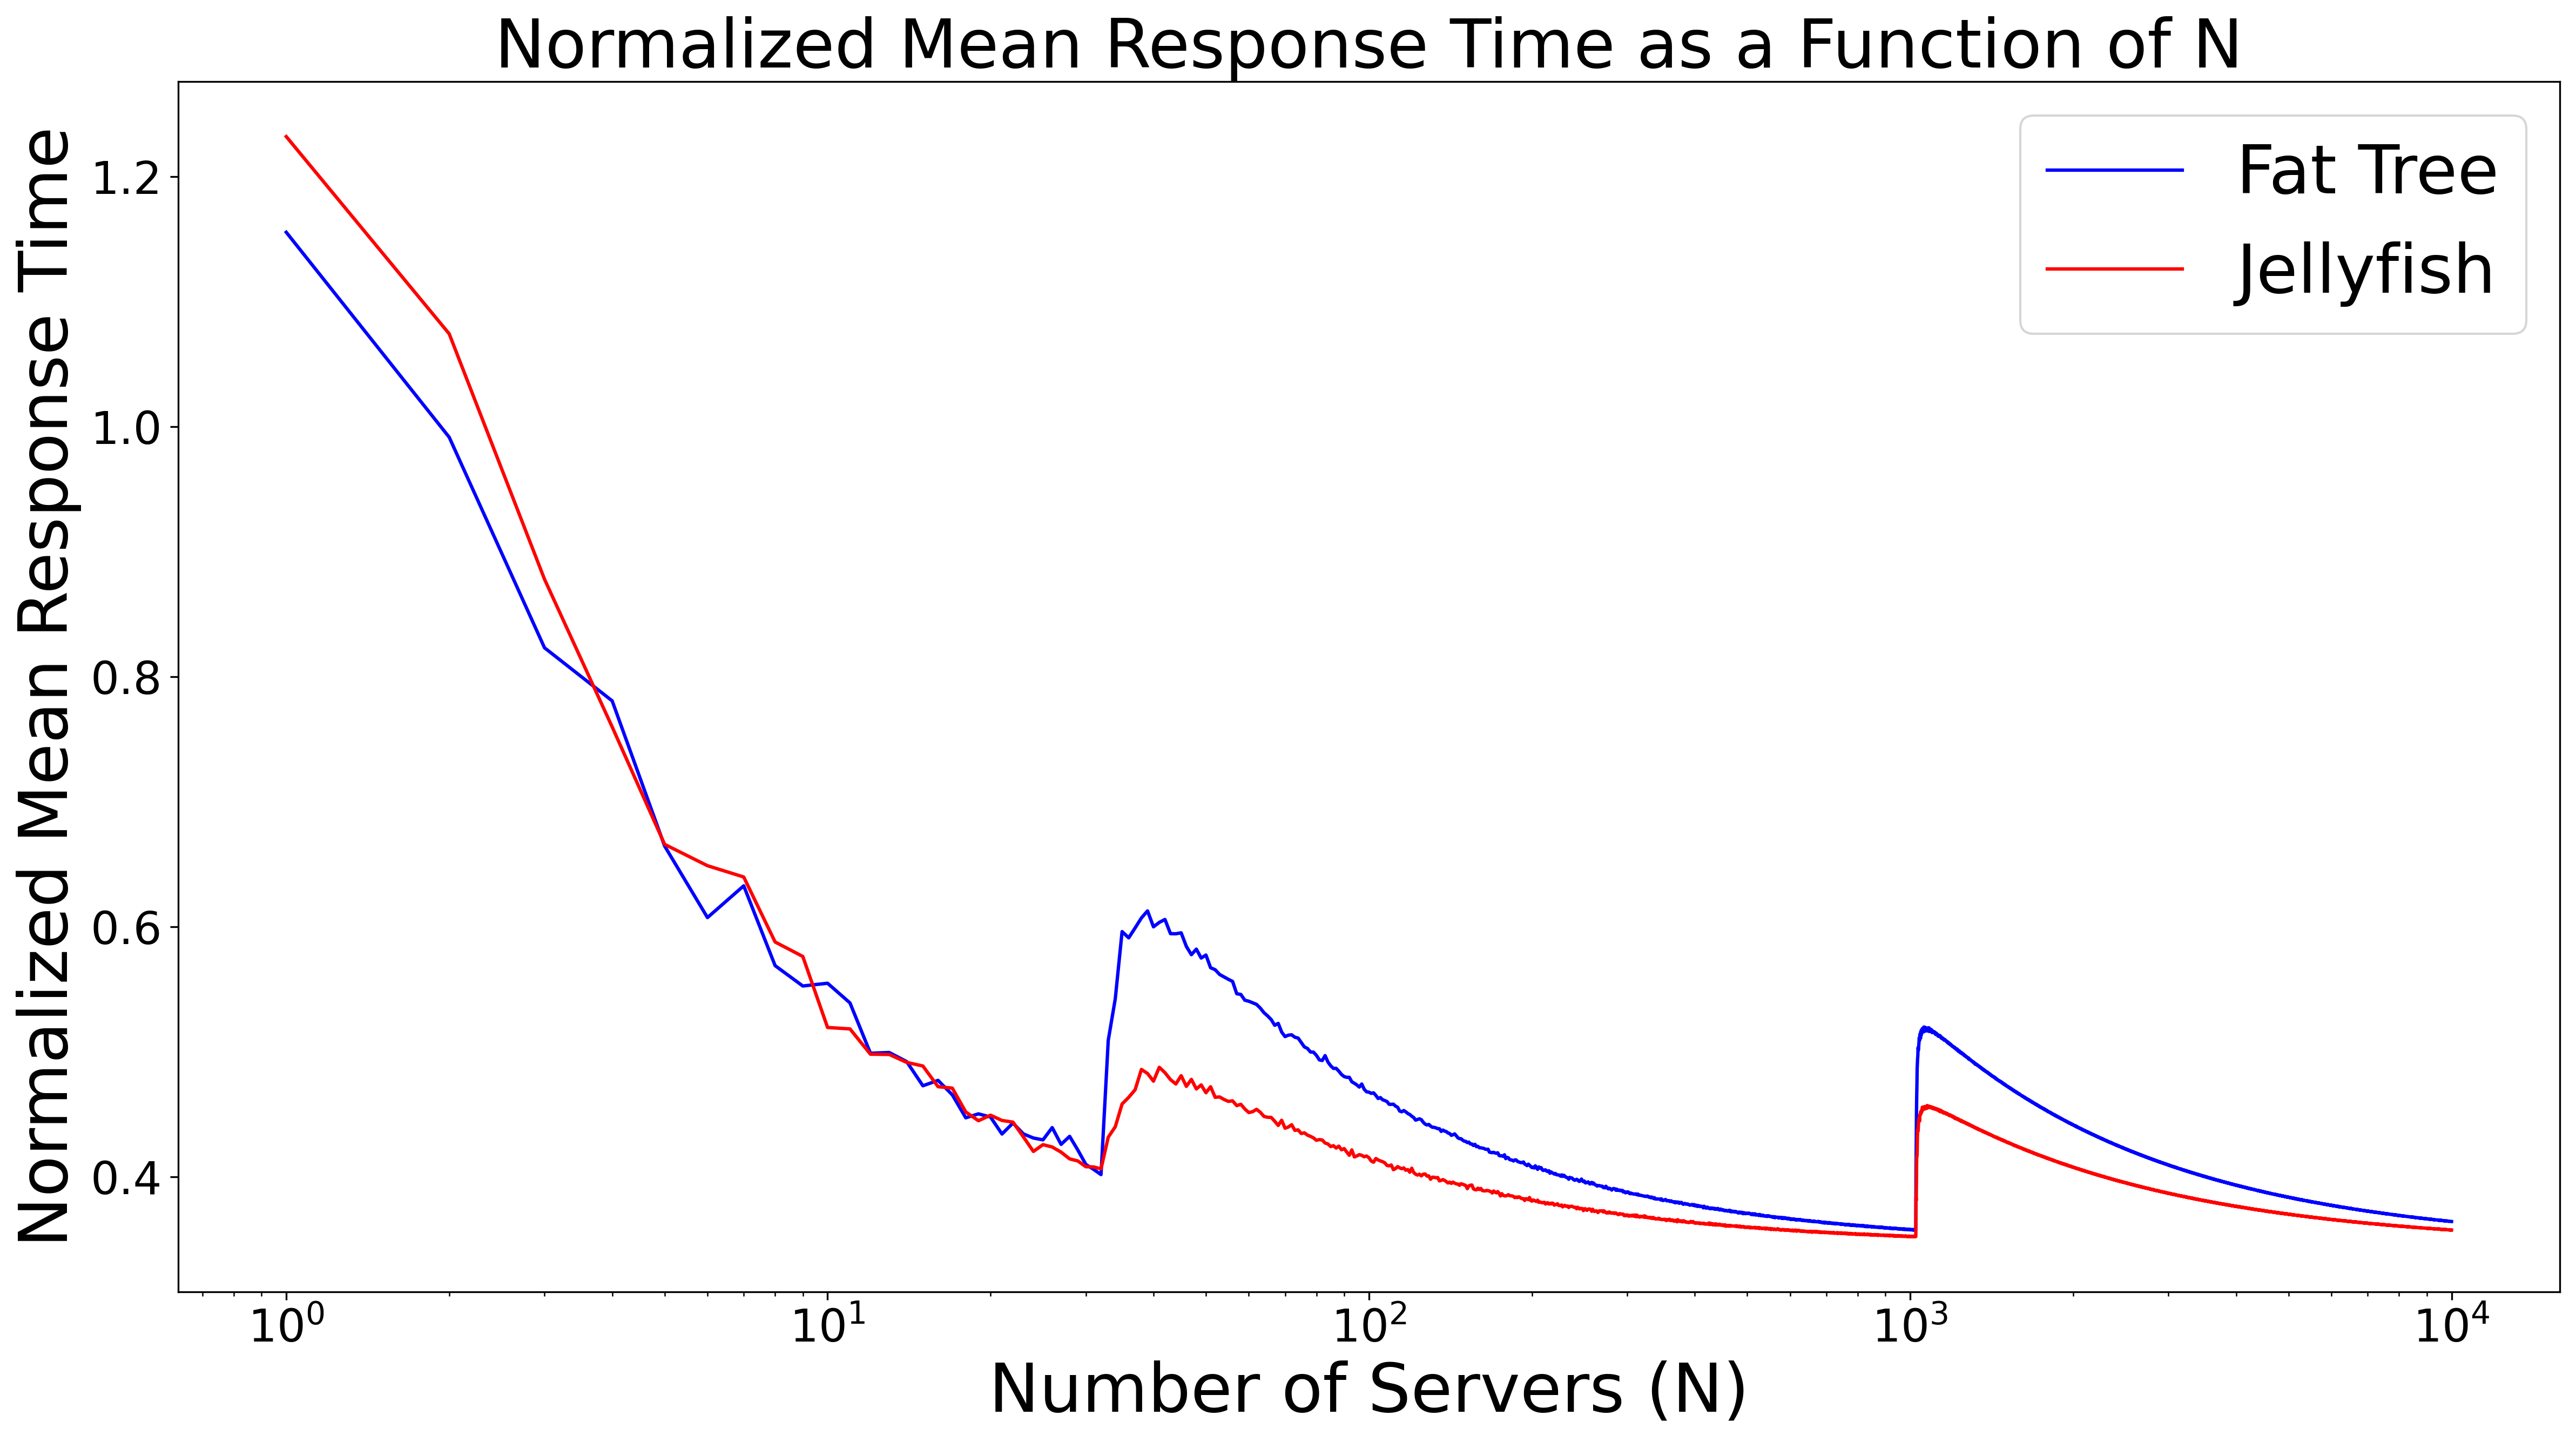

In [ ]:
import matplotlib.pyplot as plt

# Plot the normalized mean response times as a function of N
fig, ax = plt.subplots(figsize=[16, 9], dpi=300)  # Improved resolution and aspect ratio
ax.plot([i + 1 for i in range(10000)], mean_rt_fattree, color="blue", label="Fat Tree")
ax.plot([i + 1 for i in range(10000)], mean_rt_jellyfish, color="red", label="Jellyfish")

# Set the labels and title with larger font sizes
ax.set_xlabel("Number of Servers (N)", fontsize=30)
ax.set_ylabel("Normalized Mean Response Time", fontsize=30)
ax.set_title("Normalized Mean Response Time as a Function of N", fontsize=30)

# Set the legend with larger font size
ax.legend(fontsize=30)

# Set the tick parameters for better readability
ax.tick_params(axis='both', which='major', labelsize=20)

# Set the x-scale to logarithmic
ax.set_xscale("log")

# Disable the grid for better readability
ax.grid(False)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Recalculate the optimal number of servers
optimal_fat_tree_servers = np.argmin(job_running_cost_fattree) + 1
optimal_jellyfish_servers = np.argmin(job_running_cost_jellyfish) + 1

print("Recalculated optimal number of servers for Fat-Tree topology:", optimal_fat_tree_servers)
print("Recalculated optimal number of servers for Jellyfish topology:", optimal_jellyfish_servers)


Recalculated optimal number of servers for Fat-Tree topology: 32
Recalculated optimal number of servers for Jellyfish topology: 242


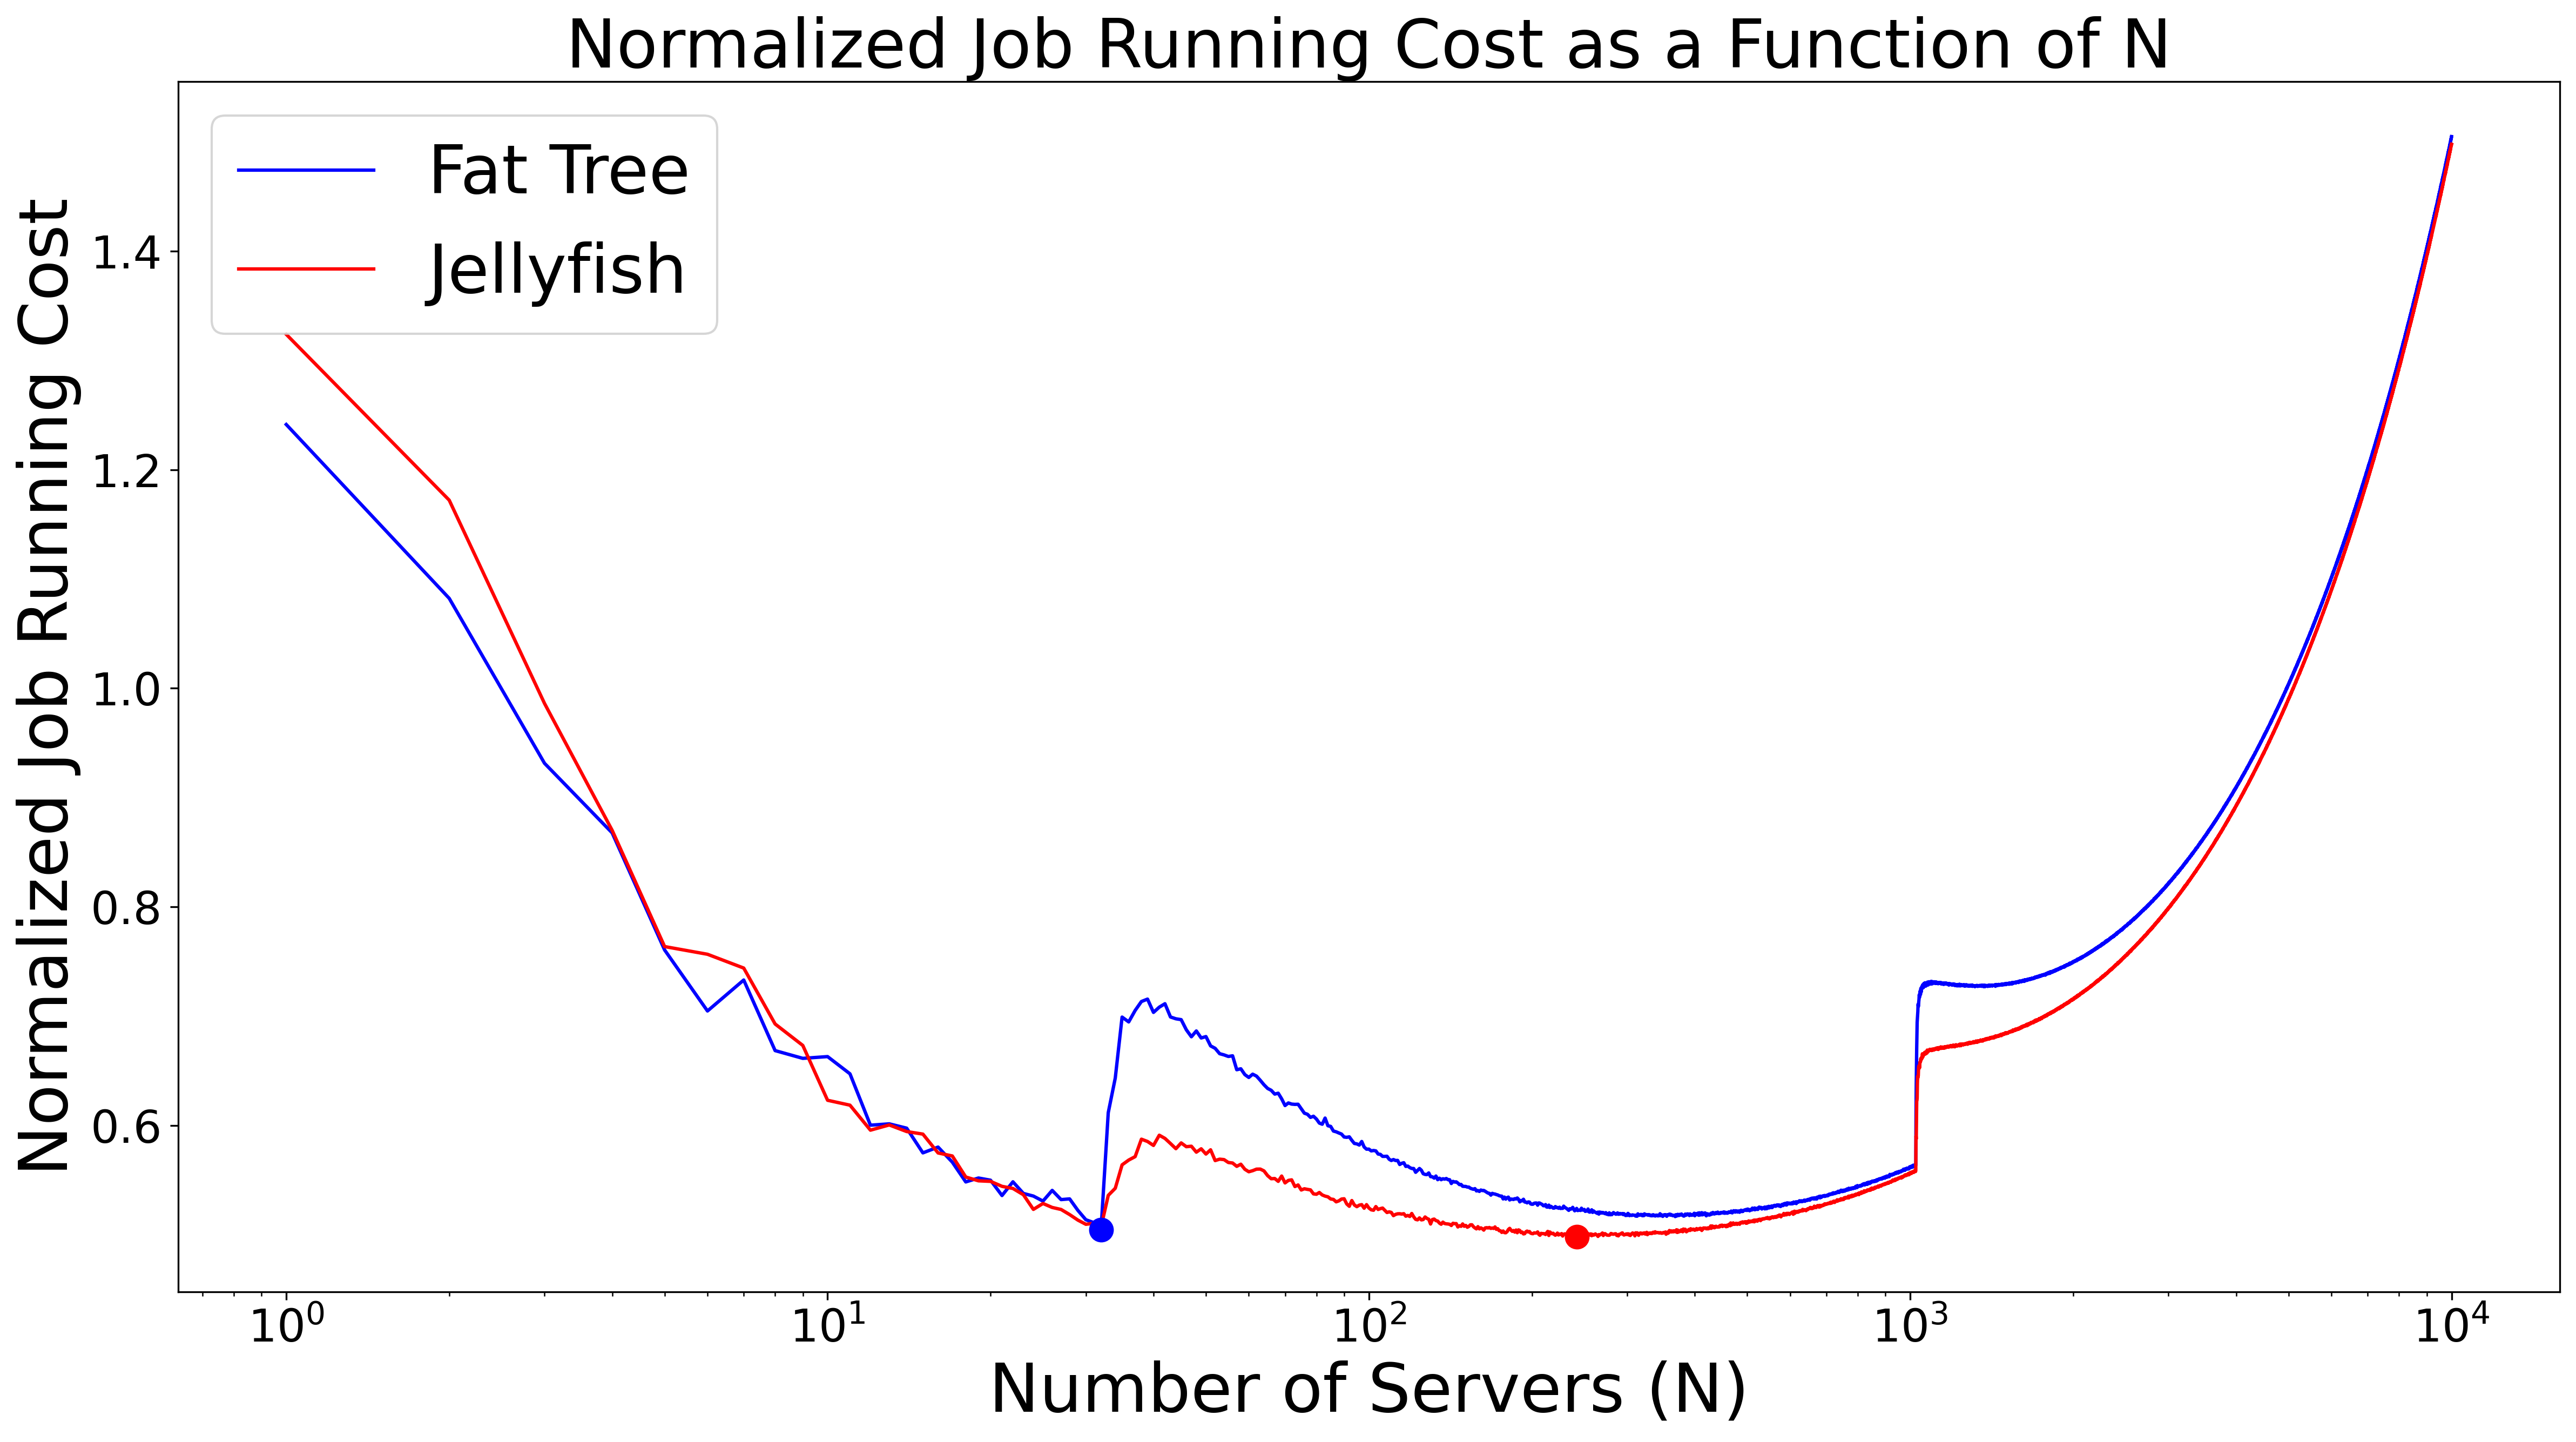

In [ ]:
# Plot the normalized job running costs as a function of N
fig, ax = plt.subplots(figsize=[16, 9], dpi=300)  # Improved resolution and aspect ratio
ax.plot([i + 1 for i in range(10000)], job_running_cost_fattree, color="blue", label="Fat Tree")
ax.plot([i + 1 for i in range(10000)], job_running_cost_jellyfish, color="red", label="Jellyfish")

# Highlight the optimal points
ax.plot(optimal_fat_tree_servers, job_running_cost_fattree[optimal_fat_tree_servers-1], 'bo', markersize=10)
ax.plot(optimal_jellyfish_servers, job_running_cost_jellyfish[optimal_jellyfish_servers-1], 'ro', markersize=10)

# Set the labels and title with larger font sizes
ax.set_xlabel("Number of Servers (N)", fontsize=30)
ax.set_ylabel("Normalized Job Running Cost", fontsize=30)
ax.set_title("Normalized Job Running Cost as a Function of N", fontsize=30)

# Set the legend with larger font size
ax.legend(fontsize=30)

# Set the tick parameters for better readability
ax.tick_params(axis='both', which='major', labelsize=20)

# Set the x-scale to logarithmic
ax.set_xscale("log")

# Disable the grid for better readability
ax.grid(False)

# Show the plot
plt.tight_layout()
plt.show()
